In [1]:
import sframe
products = sframe.SFrame('amazon_baby.gl/')

[INFO] sframe.cython.cy_server: SFrame v2.1 started. Logging /tmp/sframe_server_1483528706.log


In [2]:
def remove_punctuation(text):
    import string
    return text.translate(None, string.punctuation) 

products['review_clean'] = products['review'].apply(remove_punctuation)

In [3]:
products = products[products['rating'] != 3]

In [4]:
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)

In [5]:
train_data, test_data = products.random_split(.8, seed=1)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
     # Use this token pattern to keep single-letter words
# First, learn vocabulary from the training data and assign columns to words
# Then convert the training data into a sparse matrix
train_matrix = vectorizer.fit_transform(train_data['review_clean'])
# Second, convert the test data into a sparse matrix, using the same word-column mapping
test_matrix = vectorizer.transform(test_data['review_clean'])

In [7]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(train_matrix, train_data['sentiment'].to_numpy())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true=test_data['sentiment'].to_numpy(), y_pred=model.predict(test_matrix))
print "Test Accuracy: %s" % accuracy

Test Accuracy: 0.932325413967


In [9]:
baseline = len(test_data[test_data['sentiment'] == 1])/float(len(test_data))
print "Baseline accuracy (majority class classifier): %s" % baseline

Baseline accuracy (majority class classifier): 0.842782577394


In [10]:
from sklearn.metrics import confusion_matrix
cmat = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=model.predict(test_matrix),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  3790
     -1       |        1        |  1451
      1       |       -1        |   805
      1       |        1        | 27290


In [11]:
fp = 1451
fn = 805
cost = 100*fp + fn
print 'Cost to manufacturer: ', cost

Cost to manufacturer:  145905


In [12]:
from sklearn.metrics import precision_score
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=model.predict(test_matrix))
print "Precision on test data: %s" % precision

Precision on test data: 0.949514630667


In [13]:
from sklearn.metrics import recall_score
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=model.predict(test_matrix))
print "Recall on test data: %s" % recall

Recall on test data: 0.971347214807


In [14]:
from numpy import array
def apply_threshold(probabilities, threshold):
    result = array([0.]*len(probabilities))
    result[probabilities >= threshold] = 1
    result[probabilities < threshold] = -1
    return result

In [15]:
test_proba = array([0.99, 0.8, 0.3, 0.5, 0.55])
print apply_threshold(test_proba, 0.6)

[ 1.  1. -1. -1. -1.]


In [16]:
probabilities = model.predict_proba(test_matrix)[:,1]

In [17]:
predict0_5 = apply_threshold(probabilities, 0.5)
predict0_9 = apply_threshold(probabilities, 0.9)

In [18]:
sum(predict0_5 == 1.)

28741

In [19]:
sum(predict0_9 == 1.)

25062

In [20]:
precision = precision_score(y_true=test_data['sentiment'].to_numpy(), 
                            y_pred=predict0_9)
print "Precision on test data with threshold 0.9: %s" % precision

Precision on test data with threshold 0.9: 0.981565717022


In [21]:
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=predict0_9)
print "Recall on test data with threshold 0.9: %s" % recall

Recall on test data with threshold 0.9: 0.875600640683


In [22]:
from numpy import linspace
threshold_values = linspace(0.5, 1, num=100)
print threshold_values

[ 0.5         0.50505051  0.51010101  0.51515152  0.52020202  0.52525253
  0.53030303  0.53535354  0.54040404  0.54545455  0.55050505  0.55555556
  0.56060606  0.56565657  0.57070707  0.57575758  0.58080808  0.58585859
  0.59090909  0.5959596   0.6010101   0.60606061  0.61111111  0.61616162
  0.62121212  0.62626263  0.63131313  0.63636364  0.64141414  0.64646465
  0.65151515  0.65656566  0.66161616  0.66666667  0.67171717  0.67676768
  0.68181818  0.68686869  0.69191919  0.6969697   0.7020202   0.70707071
  0.71212121  0.71717172  0.72222222  0.72727273  0.73232323  0.73737374
  0.74242424  0.74747475  0.75252525  0.75757576  0.76262626  0.76767677
  0.77272727  0.77777778  0.78282828  0.78787879  0.79292929  0.7979798
  0.8030303   0.80808081  0.81313131  0.81818182  0.82323232  0.82828283
  0.83333333  0.83838384  0.84343434  0.84848485  0.85353535  0.85858586
  0.86363636  0.86868687  0.87373737  0.87878788  0.88383838  0.88888889
  0.89393939  0.8989899   0.9040404   0.90909091  0.

In [23]:
precision_all = []
recall_all = []
label = test_data['sentiment'].to_numpy()
for i in range(len(threshold_values)):
    precision_all.append(precision_score(label, apply_threshold(probabilities, threshold_values[i])))
    recall_all.append(recall_score(label, apply_threshold(probabilities, threshold_values[i])))

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_pr_curve(precision, recall, title):
    plt.rcParams['figure.figsize'] = 7, 5
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(precision, recall, 'b-', linewidth=4.0, color = '#B0017F')
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.rcParams.update({'font.size': 16})

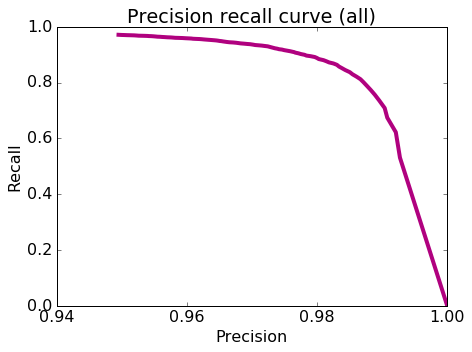

In [25]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve (all)')

### Precision-Recall on all baby related items

In [26]:
baby_reviews = test_data[test_data['name'].apply(lambda x: 'baby' in x.lower())]

In [27]:
baby_matrix = vectorizer.transform(baby_reviews['review_clean'])
probabilities = model.predict_proba(baby_matrix)[:,1]

In [28]:
precision_all_baby = []
recall_all_baby = []
label = baby_reviews['sentiment'].to_numpy()
for i in range(len(threshold_values)):
    precision_all_baby.append(precision_score(label, apply_threshold(probabilities, threshold_values[i])))
    recall_all_baby.append(recall_score(label, apply_threshold(probabilities, threshold_values[i])))

In [29]:
min(threshold_values[array(precision_all_baby) >= 0.965])

0.73232323232323238

In [30]:
min(threshold_values[array(precision_all) >= 0.965])

0.70707070707070707

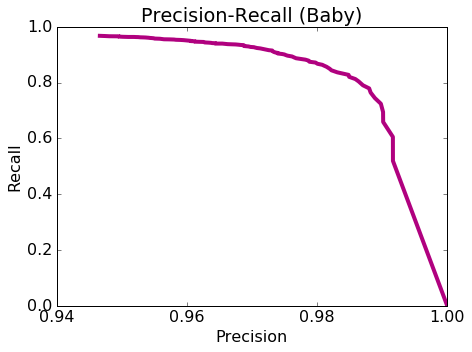

In [32]:
plot_pr_curve(precision_all_baby, recall_all_baby, "Precision-Recall (Baby)")

In [33]:
float(1451)/(1451+27290)

0.050485369333008595

In [38]:
float(27290)/(27290+805)

0.9713472148069051

In [35]:
recall = recall_score(y_true=test_data['sentiment'].to_numpy(),
                      y_pred=array([1]*len(test_data)))
print "Recall on test data where all the predictions are +1: %s" % recall

Recall on test data where all the predictions are +1: 1.0


In [37]:
cmat_th0_98 = confusion_matrix(y_true=test_data['sentiment'].to_numpy(),
                        y_pred=apply_threshold(model.predict_proba(test_matrix)[:,1], 0.98),
                        labels=model.classes_)    # use the same order of class as the LR model.
print ' target_label | predicted_label | count '
print '--------------+-----------------+-------'
# Print out the confusion matrix.
# NOTE: Your tool may arrange entries in a different order. Consult appropriate manuals.
for i, target_label in enumerate(model.classes_):
    for j, predicted_label in enumerate(model.classes_):
        print '{0:^13} | {1:^15} | {2:5d}'.format(target_label, predicted_label, cmat_th0_98[i,j])

 target_label | predicted_label | count 
--------------+-----------------+-------
     -1       |       -1        |  5048
     -1       |        1        |   193
      1       |       -1        |  8222
      1       |        1        | 19873
